# BigQuery Exploration

In [ ]:
library(bigrquery)
library(repr)
bigrquery::bq_auth(path = "/content/key-file")
project <- 'isb-cgc-outreach'

## SQL queries
SQL queries are fundamentally very similar to subsetting R data frames, where the syntax of subsetting an R data frame is as follows:

> *dataframe*[ ,*column* ][ *conditional* ]

The equivalent operation in SQL would look like this:

> SELECT *column* FROM *table* WHERE *conditional*



## Clinical and cohort queries
In this section we want to showcase how researchers can find clinical information of GDC cases. How can you quickly construct a cohort. As an example, how old are the patients for each case in a given project?

Tables used: *isb-cgc-bq.TCGA.clinical_gdc_current*

In [ ]:
# Our first query is to retrieve the columns present
column_sql <- "SELECT 
    column_name 
FROM isb-cgc-bq.TCGA.INFORMATION_SCHEMA.COLUMNS 
WHERE table_name = 'clinical_gdc_current'"

column_query <- bq_project_query(project, query=column_sql)
case_df <- as.vector(unlist(bq_table_download(column_query)))
paste(case_df, collapse=', ')

[1] "submitter_id, case_id, diag__treat__count, primary_site, disease_type, proj__name, proj__project_id, demo__demographic_id, demo__gender, demo__race, demo__ethnicity, demo__vital_status, demo__days_to_birth, demo__year_of_birth, demo__age_at_index, demo__year_of_death, demo__days_to_death, demo__state, demo__created_datetime, demo__updated_datetime, diag__diagnosis_id, diag__ajcc_clinical_n, diag__masaoka_stage, diag__ajcc_clinical_m, diag__primary_diagnosis, diag__primary_gleason_grade, diag__year_of_diagnosis, diag__figo_stage, diag__progression_or_recurrence, diag__ajcc_pathologic_m, diag__site_of_resection_or_biopsy, diag__ajcc_staging_system_edition, diag__icd_10_code, diag__age_at_diagnosis, diag__ajcc_clinical_t, diag__days_to_last_follow_up, diag__ajcc_pathologic_stage, diag__tumor_grade, diag__last_known_disease_status, diag__ann_arbor_extranodal_involvement, diag__ajcc_clinical_stage, diag__secondary_gleason_grade, diag__synchronous_malignancy, diag__morphology, diag__ajcc_pathologic_t, diag__igcccg_stage, diag__classification_of_tumor, diag__ann_arbor_clinical_stage, diag__ann_arbor_b_symptoms, diag__tumor_stage, diag__prior_treatment, diag__ajcc_pathologic_n, diag__tissue_or_organ_of_origin, diag__prior_malignancy, diag__state, diag__created_datetime, diag__updated_datetime, exp__exposure_id, exp__height, exp__weight, exp__bmi, exp__years_smoked, exp__pack_years_smoked, exp__cigarettes_per_day, exp__alcohol_history, exp__state, exp__created_datetime, exp__updated_datetime, state, updated_datetime"

In [ ]:
# our second query retrieves the ages of all TCGA-BRCA cases
case_sql <- "SELECT
  submitter_id,
  demo__age_at_index,
  demo__vital_status,
FROM `isb-cgc-bq.TCGA.clinical_gdc_current`
WHERE proj__project_id = 'TCGA-BRCA'
"
case_query <- bq_project_query(project, query=case_sql)
case_df <- as.data.frame(bq_table_download(case_query))
head(case_df)

# Try substituting alternate or adding columns such as:
#   demo__vital_status
#   demo__race
# Find all the unique values that are in a column by querying only for:
#   distinct demo__race
# Try subseting the results by use of the where clause:
#   proj__project_id = 'TCGA-BRCA'
#   demo__age_at_index <= 70 AND demo__age_at_index >= 40

,demo__age_at_index,demo__vital_status
,<int>,<chr>
1,81,Alive
2,76,Alive
3,40,Alive
4,69,Alive
5,46,Dead
6,61,Alive


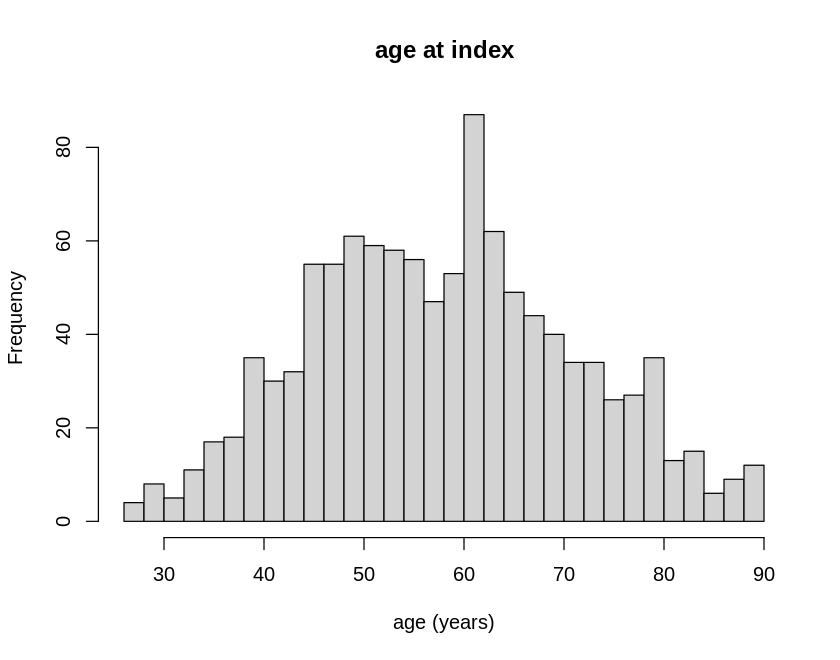

In [ ]:
# since we have the data in R we can directly generate visuals
options(repr.plot.width=7, repr.plot.height=5.5)
case_num <- length(unique(case_df[,2]))
hist(case_df[,2], breaks=case_num/2, main='age at index', xlab='age (years)')

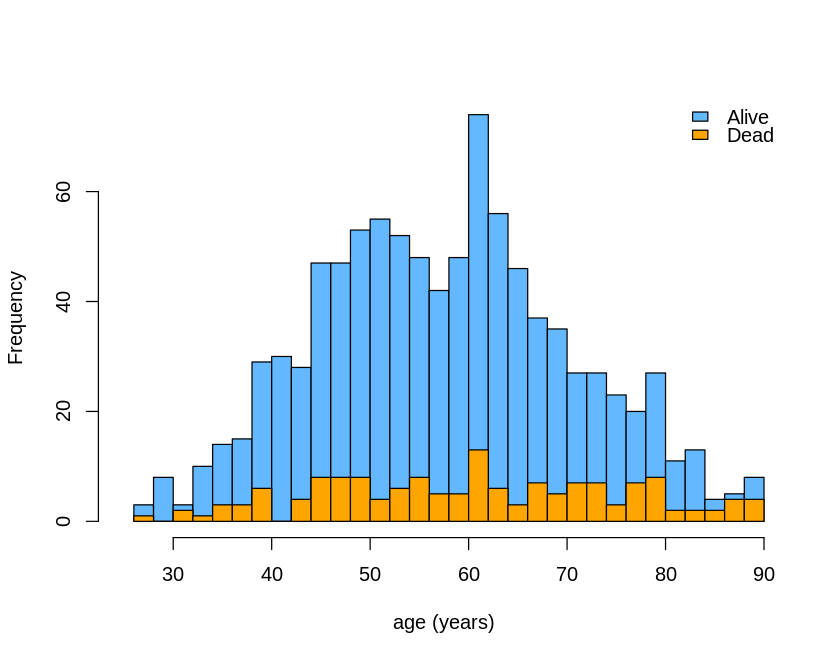

In [ ]:
# including separating by vital status
hist(case_df[case_df[,3] == 'Alive',2], 
     breaks=case_num/2, xlim=c(25,90), 
     col='steelblue1', main='', xlab='age (years)')
hist(case_df[case_df[,3] == 'Dead',2], 
     breaks=case_num/2, add=1, col='orange')
legend('topright', bty='n', legend=c('Alive', 'Dead'), fill=c('steelblue1', 'orange'))

## Gene expression
Another common question researchers encounter is, given a gene of interest what is the expression pattern in cancers? Using the GDC expression tables it's possible to retrieve huge amounts of information and do high level comparisons quickly.

Tables used: *isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current*

In [ ]:
# a query to retrieve FPKM_UQ values for one specific gene (CCNB1)
expr_sql <- "SELECT
  case_barcode,
  aliquot_barcode,
  sample_type_name,
  HTSeq__FPKM_UQ
FROM `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current`
WHERE project_short_name = 'TCGA-BRCA'
  AND gene_name = 'BRCA1' #'CCNB1'"

expr_query <- bq_project_query(project, query=expr_sql)
expr_df <- bq_table_download(expr_query)
head(expr_df)

# try changing the project_short_name to 'TCGA-LUAD'
# or substitute HTSeq__FPKM_UQ to retrieve other measures
#    HTSeq__counts
#    HTSeq__FPKM
# change the gene name
#    BRCA1
#    BRCA2
#    FOXA1

case_barcode,aliquot_barcode,sample_type_name,HTSeq__FPKM_UQ
<chr>,<chr>,<chr>,<dbl>
TCGA-E2-A572,TCGA-E2-A572-01A-13R-A31O-07,Primary Tumor,18923.580
TCGA-BH-A0BQ,TCGA-BH-A0BQ-11A-33R-A115-07,Solid Tissue Normal,35066.190
TCGA-B6-A0IJ,TCGA-B6-A0IJ-01A-11R-A034-07,Primary Tumor,8246.802
TCGA-BH-A0DX,TCGA-BH-A0DX-01A-11R-A115-07,Primary Tumor,25733.895
TCGA-A7-A4SD,TCGA-A7-A4SD-01A-11R-A266-07,Primary Tumor,56027.117
TCGA-AR-A24X,TCGA-AR-A24X-01A-11R-A169-07,Primary Tumor,65654.935


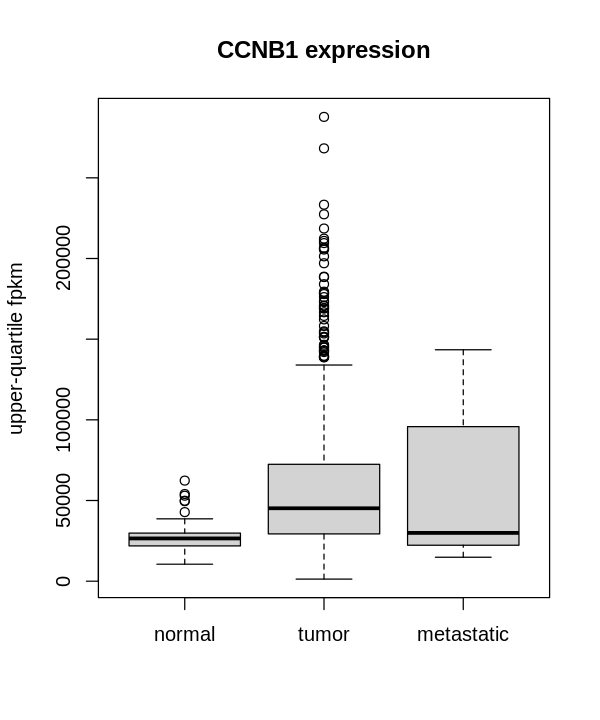

In [ ]:
options(repr.plot.width=5, repr.plot.height=6)
tumor <- unlist(expr_df[expr_df[,3] == 'Primary Tumor',4])
normal <- unlist(expr_df[expr_df[,3] == 'Solid Tissue Normal',4])
metastatic <- unlist(expr_df[expr_df[,3] == 'Metastatic',4])

boxplot(list(normal, tumor, metastatic), names=c('normal', 'tumor', 'metastatic'), main='CCNB1 expression', ylab='upper-quartile fpkm')

As the size of the data of interest increases, calculating statistics on a local machine may become prohibitive. One of the benefits of BigQuery is that it scales compute power to the demands of the query. We can functions built into BQ to generate summary statistics.

In [ ]:
# This query will calculate averages, standard deviations, maximums, and minimums
summ_sql <- "SELECT
  project_short_name,
  sample_type_name,
  count( distinct aliquot_barcode ) count_aliq,
  avg(HTSeq__FPKM_UQ) avg_fpkm,
  stddev(HTSeq__FPKM_UQ) sdv_fpkm,
  max(HTSeq__FPKM_UQ) max_fpkm,
  min(HTSeq__FPKM_UQ) min_fpkm
FROM `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current`
WHERE gene_name = 'CCNB1'
GROUP BY project_short_name, sample_type_name
"

summ_query <- bq_project_query(project, query=summ_sql)
summ_df <- bq_table_download(summ_query)
head(summ_df)

# Other functions such as count and distinct can add useful information
#    count( distinct aliquot_barcode )
# Retrieve results for all genes or for all projects by
# removing gene_name from the WHERE clause 
# and adding it to SELECT and GROUP BY

project_short_name,sample_type_name,count_aliq,avg_fpkm,sdv_fpkm,max_fpkm,min_fpkm
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-KIRC,Primary Tumor,538,121424.63,127717.885,1475843.49,30926.66
TCGA-LAML,Primary Blood Derived Cancer - Peripheral Blood,151,260716.04,158005.676,812492.50,36127.69
TCGA-KIRP,Primary Tumor,288,101011.04,87973.475,629245.35,25906.31
TCGA-CESC,Primary Tumor,304,1067673.23,451652.372,3026999.46,296749.85
TCGA-PAAD,Primary Tumor,177,222329.87,143295.594,808567.04,39667.17
TCGA-READ,Primary Tumor,166,849050.52,419447.409,2599759.74,162938.10
TCGA-BRCA,Solid Tissue Normal,113,83936.42,42956.424,360053.36,27281.68
TCGA-ESCA,Primary Tumor,161,545854.67,298643.670,1579628.48,108445.40
TCGA-KIRC,Solid Tissue Normal,72,60710.37,35986.430,263844.18,33512.31


In [ ]:
# summ_sql <- "SELECT
#  sample_type_name,
#  project_short_name,
#  avg(HTSeq__FPKM_UQ) avg_fpkm,
#  stddev(HTSeq__FPKM_UQ) sdv_fpkm,
#  max(HTSeq__FPKM_UQ) max_fpkm,
#  min(HTSeq__FPKM_UQ) min_fpkm
#FROM `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current`
#WHERE gene_name = 'CCNB1'
#GROUP BY project_short_name,sample_type_name"

## Genome annotation
If we need annotatio information about a gene it's possible to quickly retrieve Gencode annotation from ISB-CGC hosted BigQuery tables.

Table: *isb-cgc-bq.GENCODE_versioned.annotation_gtf_hg38_v22*

In [ ]:
annot_sql <- "SELECT * 
FROM `isb-cgc-bq.GENCODE_versioned.annotation_gtf_hg38_v22`
WHERE gene_name = 'CCNB1' 
  AND transcript_name = 'CCNB1-001'"

annot_query <- bq_project_query(project, query=annot_sql)
annot_df <- bq_table_download(annot_query)
annot_df

seq_name,source,feature,start,end,frame,strand,gene_name,gene_id,gene_id_v,⋯,ccds_id_v,protein_id,protein_id_v,havana_gene,havana_gene_v,havana_transcript,havana_transcript_v,level,tag,ont
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
chr5,HAVANA,CDS,69171270,69171452,.,+,CCNB1,ENSG00000134057,ENSG00000134057.13,⋯,CCDS3997.1,ENSP00000256442,ENSP00000256442.5,OTTHUMG00000097817,OTTHUMG00000097817.3,OTTHUMT00000215084,OTTHUMT00000215084.1,2,basic;appris_principal_1;CCDS,NA
chr5,HAVANA,CDS,69174877,69175113,.,+,CCNB1,ENSG00000134057,ENSG00000134057.13,⋯,CCDS3997.1,ENSP00000256442,ENSP00000256442.5,OTTHUMG00000097817,OTTHUMG00000097817.3,OTTHUMT00000215084,OTTHUMT00000215084.1,2,basic;appris_principal_1;CCDS,NA
chr5,HAVANA,CDS,69167908,69168078,.,+,CCNB1,ENSG00000134057,ENSG00000134057.13,⋯,CCDS3997.1,ENSP00000256442,ENSP00000256442.5,OTTHUMG00000097817,OTTHUMG00000097817.3,OTTHUMT00000215084,OTTHUMT00000215084.1,2,basic;appris_principal_1;CCDS,NA
chr5,HAVANA,CDS,69167263,69167283,.,+,CCNB1,ENSG00000134057,ENSG00000134057.13,⋯,CCDS3997.1,ENSP00000256442,ENSP00000256442.5,OTTHUMG00000097817,OTTHUMG00000097817.3,OTTHUMT00000215084,OTTHUMT00000215084.1,2,basic;appris_principal_1;CCDS,NA
chr5,HAVANA,exon,69177524,69178245,.,+,CCNB1,ENSG00000134057,ENSG00000134057.13,⋯,CCDS3997.1,ENSP00000256442,ENSP00000256442.5,OTTHUMG00000097817,OTTHUMG00000097817.3,OTTHUMT00000215084,OTTHUMT00000215084.1,2,basic;appris_principal_1;CCDS,NA
chr5,HAVANA,CDS,69177239,69177349,.,+,CCNB1,ENSG00000134057,ENSG00000134057.13,⋯,CCDS3997.1,ENSP00000256442,ENSP00000256442.5,OTTHUMG00000097817,OTTHUMG00000097817.3,OTTHUMT00000215084,OTTHUMT00000215084.1,2,basic;appris_principal_1;CCDS,NA
chr5,HAVANA,CDS,69177524,69177628,.,+,CCNB1,ENSG00000134057,ENSG00000134057.13,⋯,CCDS3997.1,ENSP00000256442,ENSP00000256442.5,OTTHUMG00000097817,OTTHUMG00000097817.3,OTTHUMT00000215084,OTTHUMT00000215084.1,2,basic;appris_principal_1;CCDS,NA
chr5,HAVANA,UTR,69177629,69178245,.,+,CCNB1,ENSG00000134057,ENSG00000134057.13,⋯,CCDS3997.1,ENSP00000256442,ENSP00000256442.5,OTTHUMG00000097817,OTTHUMG00000097817.3,OTTHUMT00000215084,OTTHUMT00000215084.1,2,basic;appris_principal_1;CCDS,NA
chr5,HAVANA,CDS,69175397,69175537,.,+,CCNB1,ENSG00000134057,ENSG00000134057.13,⋯,CCDS3997.1,ENSP00000256442,ENSP00000256442.5,OTTHUMG00000097817,OTTHUMG00000097817.3,OTTHUMT00000215084,OTTHUMT00000215084.1,2,basic;appris_principal_1;CCDS,NA


## Mutation data
You may encounter a mutation and wonder if it's represented in other cancer data. Given the gene annotation data from above we can query the somatic mutation table for mutations within a gene.

Table: *isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current*

In [ ]:
# this query retrieves all mutations falling between the start codon and the stop codon of our gene.
mut_sql <- "SELECT case_barcode, 
    Chromosome, 
    Start_Position, 
    End_Position, 
    Reference_Allele, 
    Tumor_Seq_Allele1, 
    Tumor_Seq_Allele2
FROM `isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current`
WHERE Chromosome = 'chr5'
    AND Start_Position >= 69167263
    AND End_Position <= 69177631"

mut_query <- bq_project_query(project, query=mut_sql)
mut_df <- bq_table_download(mut_query)
head(mut_df)
nrow(mut_df)

case_barcode,Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
TCGA-AP-A059,chr5,69175531,69175531,T,T,C
TCGA-06-1805,chr5,69175091,69175091,G,G,-
TCGA-13-0751,chr5,69175528,69175529,-,-,CTCCTTCATCATA
TCGA-B5-A11E,chr5,69177254,69177254,C,C,T
TCGA-CM-5861,chr5,69174975,69174975,C,C,G
TCGA-HT-8012,chr5,69171447,69171447,C,C,T


[1] 68

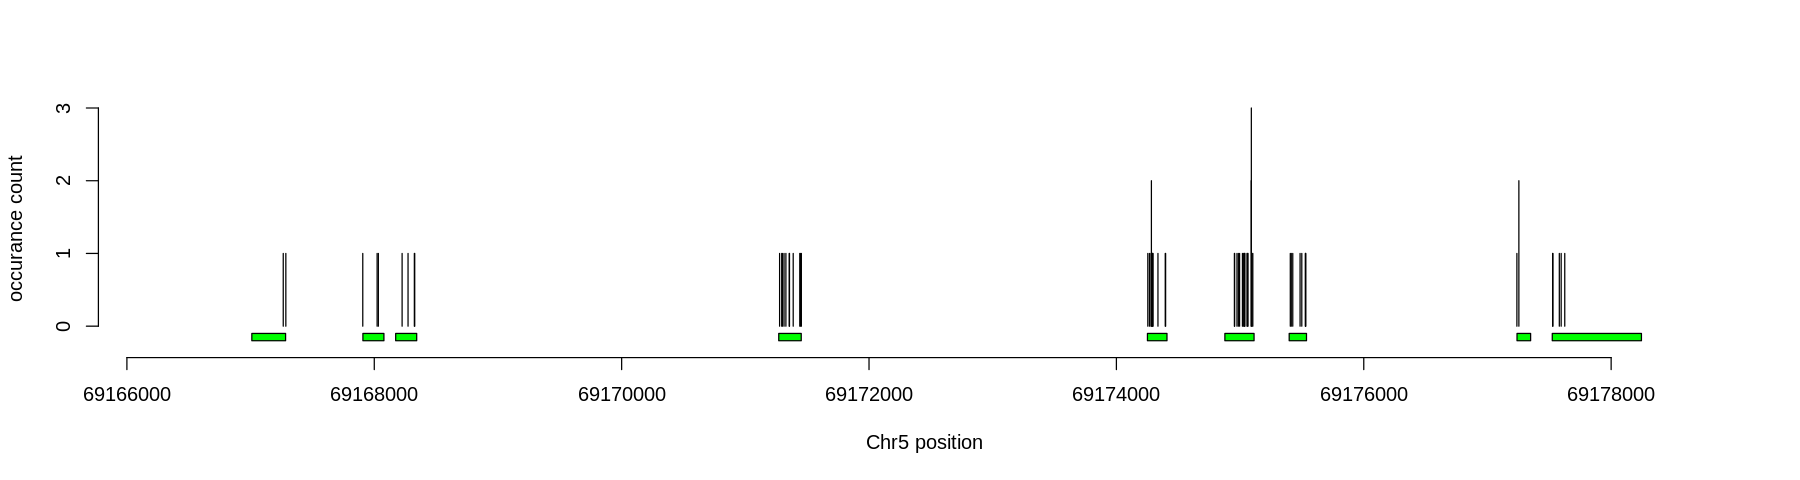

In [ ]:
# we can plot the positions and number of mutations on the chromosome
options(repr.plot.width=15, repr.plot.height=4)
mut_count <- table(mut_df[,3])
max_count <- max(mut_count)
plot(NA, xlim=c(min(mut_df[,3])-1000, max(mut_df[,3])+1000), ylim=c(-0.3,max_count), 
     yaxt='n', bty='n', main='', xlab='Chr5 position', ylab='occurance count')
jnk <- apply(annot_df[annot_df$feature == 'exon',], 1, function(row){
    rect(row[4], -0.2, row[5], -0.1, col='green')
})
axis(2, at=seq(0,3,1))
jnk <- sapply(1:length(mut_count), function(ix){
    x <- as.numeric(names(mut_count)[ix])
    segments(x, 0, x, mut_count[ix])
    })

In [ ]:
sql <- "SELECT
    case_barcode, 
    Chromosome, 
    Start_Position, 
    End_Position, 
    Reference_Allele, 
    Tumor_Seq_Allele1, 
    Tumor_Seq_Allele2
FROM `isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current`
WHERE 
    Chromosome = 'chr5'
    AND ( (Start_Position < 69067135 and Start_Position > 69167135)
        or (End_Position > 69177358 and End_Position < 69277358) )"

query <- bq_project_query(project, query=sql)
df <- bq_table_download(query)
head(df)

case_barcode,Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
TCGA-EY-A1GI,chr5,69277338,69277338,A,A,C
TCGA-FW-A3R5,chr5,69209874,69209874,C,C,T
TCGA-DU-6392,chr5,69217801,69217801,G,G,A
TCGA-LD-A74U,chr5,69189588,69189588,C,C,T
TCGA-BS-A0UF,chr5,69255625,69255625,G,G,T
TCGA-64-5779,chr5,69226349,69226349,A,A,G


## Table joins
Many use cases for researchers require combined data from multiple of the tables we worked with in the previous examples. How do we join these data using BigQuery?

Tables:
*   *isb-cgc-bq.TCGA.clinical_gdc_current*
*   *isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current*

In [ ]:
sql <- "SELECT
    mut.case_barcode,
    mut.Chromosome, 
    mut.Start_Position, 
    mut.End_Position, 
    mut.Reference_Allele, 
    mut.Tumor_Seq_Allele1, 
    mut.Tumor_Seq_Allele2, 
    clin.demo__vital_status 
FROM `isb-cgc-bq.TCGA.clinical_gdc_current` clin
JOIN `isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current` mut 
    ON clin.submitter_id = mut.case_barcode
WHERE mut.project_short_name = 'TCGA-BRCA'"

query <- bq_project_query(project, query=sql)
df <- bq_table_download(query)
head(df)

case_barcode,Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,demo__vital_status
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
TCGA-A8-A09A,chr20,36591450,36591462,GCTGAAGGCTCCA,GCTGAAGGCTCCA,-,Alive
TCGA-A8-A09A,chr11,6617720,6617728,GGGTCAGTG,GGGTCAGTG,-,Alive
TCGA-A8-A09A,chr10,91630062,91630073,CTGGGGTGCCAT,CTGGGGTGCCAT,-,Alive
TCGA-A8-A09A,chr1,44130625,44130629,CAGTG,CAGTG,-,Alive
TCGA-A8-A09A,chr17,65137549,65137555,CCGACAC,CCGACAC,-,Alive
TCGA-A8-A09A,chr13,45398768,45398800,ATTGTATTTATAAAAGCTAAGCACAGTGTGGCA,ATTGTATTTATAAAAGCTAAGCACAGTGTGGCA,-,Alive


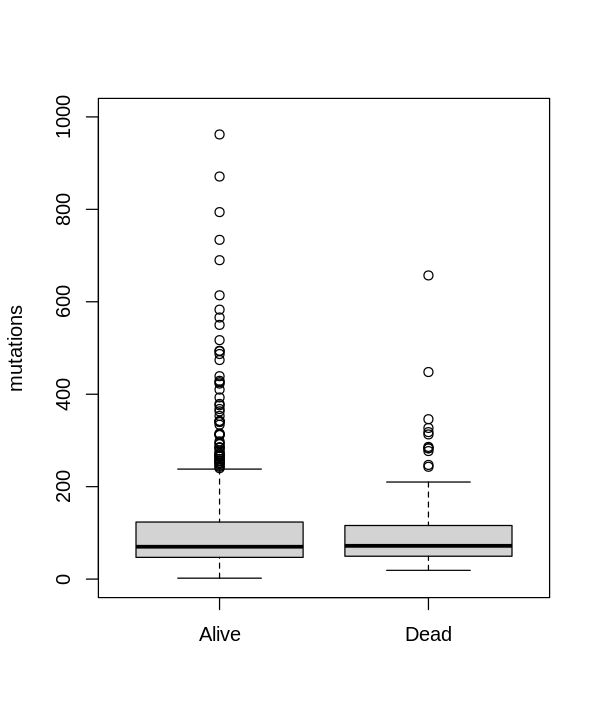

In [81]:
options(repr.plot.width=5, repr.plot.height=6)
muts_alive <- table(df[df['demo__vital_status'] == 'Alive','case_barcode'])
muts_dead <- table(df[df['demo__vital_status'] == 'Dead','case_barcode'])
boxplot(muts_alive, muts_dead, ylim=c(0,1000), 
  names=c('Alive', 'Dead'), ylab='mutations')